In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [28]:
data = pd.read_csv('data.csv') 
data.head()


,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


In [29]:

assert 'password' in data.columns and 'strength' in data.columns, "Dataset must contain 'password' and 'strength' columns."


all_chars = set(''.join(data['password'].astype(str).values))
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}  
vocab_size = len(char_to_idx) + 1


max_length = 16

def encode_password(pw):
    pw_encoded = [char_to_idx.get(c, 0) for c in str(pw)]
    if len(pw_encoded) < max_length:
        pw_encoded += [0] * (max_length - len(pw_encoded))
    else:
        pw_encoded = pw_encoded[:max_length]
    return pw_encoded

encoded_passwords = np.array([encode_password(pw) for pw in data['password']])
labels = data['strength'].values


In [30]:
X_train, X_test, y_train, y_test = train_test_split(encoded_passwords, labels, test_size=0.2, random_state=42)


In [31]:
class PasswordDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PasswordDataset(X_train, y_train)
test_dataset = PasswordDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [32]:
class PasswordCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, num_classes=3):
        super(PasswordCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

model = PasswordCNN(vocab_size).to(device)


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [34]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')


Epoch 1/30, Loss: 0.0749
Epoch 2/30, Loss: 0.0238
Epoch 3/30, Loss: 0.0155
Epoch 4/30, Loss: 0.0119
Epoch 5/30, Loss: 0.0102
Epoch 6/30, Loss: 0.0084
Epoch 7/30, Loss: 0.0082
Epoch 8/30, Loss: 0.0076
Epoch 9/30, Loss: 0.0069
Epoch 10/30, Loss: 0.0066
Epoch 11/30, Loss: 0.0063
Epoch 12/30, Loss: 0.0061
Epoch 13/30, Loss: 0.0059
Epoch 14/30, Loss: 0.0056
Epoch 15/30, Loss: 0.0056
Epoch 16/30, Loss: 0.0056
Epoch 17/30, Loss: 0.0052
Epoch 18/30, Loss: 0.0059
Epoch 19/30, Loss: 0.0053
Epoch 20/30, Loss: 0.0053
Epoch 21/30, Loss: 0.0061
Epoch 22/30, Loss: 0.0050
Epoch 23/30, Loss: 0.0054
Epoch 24/30, Loss: 0.0053
Epoch 25/30, Loss: 0.0058
Epoch 26/30, Loss: 0.0054
Epoch 27/30, Loss: 0.0054
Epoch 28/30, Loss: 0.0064
Epoch 29/30, Loss: 0.0056
Epoch 30/30, Loss: 0.0055


In [35]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 99.88%


In [36]:
## !pip install onnx

In [40]:
dummy_input = torch.randint(0, vocab_size, (1, max_length)).to(device)

torch.onnx.export(
    model,
    dummy_input,
    "password_strength_cnn.onnx",
    input_names=['input'],
    output_names=['output'],
    opset_version=11,
    do_constant_folding=True,
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print("ONNX model exported successfully for web deployment!")


ONNX model exported successfully for web deployment!


Total Test Samples: 133928
Test Accuracy: 99.88%

Classification Report:
              precision    recall  f1-score   support

        Weak       1.00      0.99      1.00     17833
     Average       1.00      1.00      1.00     99525
      Strong       1.00      1.00      1.00     16570

    accuracy                           1.00    133928
   macro avg       1.00      1.00      1.00    133928
weighted avg       1.00      1.00      1.00    133928



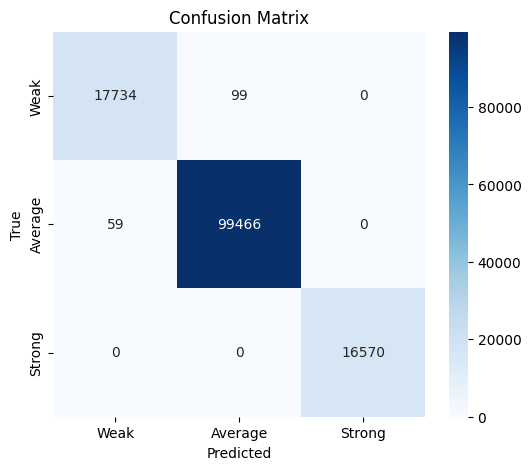

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


print(f'Total Test Samples: {total}')
print(f'Test Accuracy: {100 * correct / total:.2f}%')


print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=["Weak", "Average", "Strong"]))


cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Weak", "Average", "Strong"], yticklabels=["Weak", "Average", "Strong"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
